In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 12.3 MB/s eta 0:00:00


In [ ]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/공간정보활용 공모전/

/content/drive/.shortcut-targets-by-id/12CdYaiaXminsUG-MrYvqDyVBDHcUxd6B/공간정보활용 공모전


In [ ]:
import pandas as pd
import numpy as np
import gabojago_model

import torch
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from torchvision import transforms , datasets
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassAccuracy
import seaborn as sn

In [ ]:
sn.set(style="white")
fix_font()

In [ ]:
#npy파일 불러오기
yp_X_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/test_X_npy_file.npy'
yp_Y_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/test_Y_npy_file.npy'
yp_X_np_load = np.load(yp_X_file)
yp_Y_np_load = np.load(yp_Y_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#numpy Array⇒Tensor
#device type이 'cuda'인 tensor 완성
yp_X = torch.from_numpy(yp_X_np_load).to(device)
yp_Y = torch.from_numpy(yp_Y_np_load).to(device)

cuda:0


In [ ]:
normalize = transforms.Compose([transforms.Normalize((0.5), (0.5))])

yp_X = yp_X/255
yp_X = yp_X.float().unsqueeze(1)
yp_X = normalize(yp_X)
yp_Y = yp_Y-1

YPset = TensorDataset(yp_X, yp_Y)
YP_loader = torch.utils.data.DataLoader(YPset, batch_size=yp_Y.size(0), shuffle=False, num_workers=0)

In [ ]:
classes = ['정방형', '가로장방', '세로장방', '사다리형', '부정형', '자루형']

In [ ]:
def model_evaluation(model, YP_loader, classes):
  num_classes = len(classes)
  model.eval()
  with torch.no_grad():
    sum_acc = 0
    num_iter = 0
    model.train()
    confusion_matrix = pd.DataFrame(0, index=np.arange(num_classes), columns=np.arange(num_classes))
    for test_batch in YP_loader:
      x_i = test_batch[0].to(device)
      y_i = test_batch[1].to(device)
      y_hat_i = model(x_i)
      _, y_pred_i = torch.max(torch.nn.functional.softmax(y_hat_i, dim=1), dim=1)
      cf_matrix_recall_maker = MulticlassConfusionMatrix(num_classes= num_classes, normalize='true').to(device)
      cf_matrix_precision_maker = MulticlassConfusionMatrix(num_classes= num_classes, normalize='pred').to(device)
      cf_matrix_maker = MulticlassConfusionMatrix(num_classes= num_classes, normalize='all').to(device)
      mca = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
      mcr = MulticlassRecall(num_classes= num_classes).to(device)
      mcp = MulticlassPrecision(num_classes= num_classes).to(device)
      cf_matrix_recall = cf_matrix_recall_maker(y_pred_i, y_i)
      cf_matrix_precision = cf_matrix_precision_maker(y_pred_i, y_i)
      cf_matrix = cf_matrix_maker(y_pred_i, y_i)
      accuracy1 = mca(y_hat_i, y_i)
      accuracy2 = mca(y_pred_i, y_i)
      recall = mcr(y_pred_i, y_i)
      precision = mcp(y_pred_i, y_i)
      f1_score = 2*(precision*recall/(precision+recall))

      df_cm_r = pd.DataFrame((cf_matrix_recall).cpu().numpy(), index = classes, columns = classes)
      df_cm_p = pd.DataFrame((cf_matrix_precision).cpu().numpy(), index = classes, columns = classes)
      df_cm = pd.DataFrame((cf_matrix).cpu().numpy(), index = classes, columns = classes)

      f, axes = plt.subplots(1, 3)
      f.set_size_inches((18, 4.5))
      plt.subplot(1, 3, 1)
      sn.heatmap(df_cm_r, annot=True, cmap ='Blues')
      plt.title("Recall")
      plt.xlabel('pred')
      plt.ylabel('target')
      plt.subplot(1, 3, 2)
      sn.heatmap(df_cm_p, annot=True, cmap ='Blues')
      plt.title("Precision")
      plt.xlabel('pred')
      plt.ylabel('target')
      plt.subplot(1, 3, 3)
      sn.heatmap(df_cm, annot=True, cmap ='Blues')
      plt.title("Total")
      plt.xlabel('pred')
      plt.ylabel('target')
      plt.show()
      print(f'\naccuracy: {accuracy1}, {accuracy2}\nrecall: {recall}\nprecisoin: {precision}\nf1-score: {f1_score}')

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 12 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


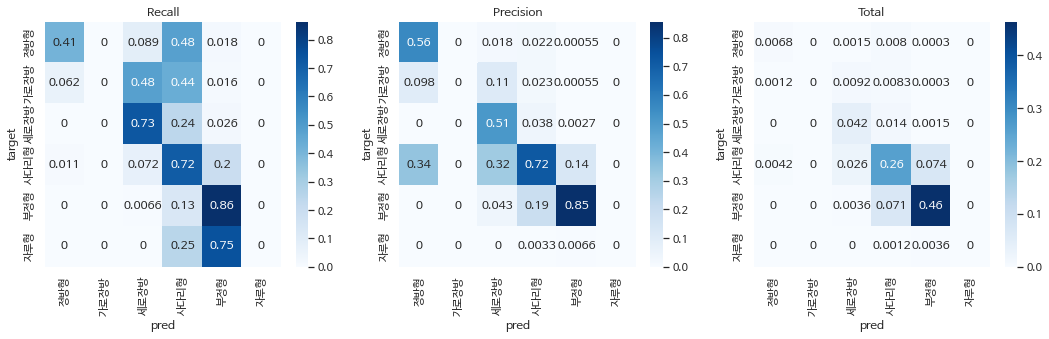


accuracy: 0.772794783115387, 0.772794783115387
recall: 0.4534853994846344
precisoin: 0.44097721576690674
f1-score: 0.4471438527107239



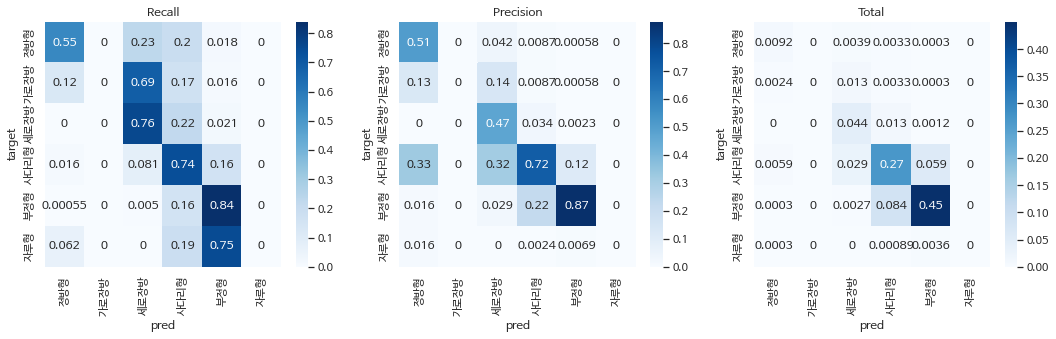


accuracy: 0.7730917930603027, 0.7730917930603027
recall: 0.48184970021247864
precisoin: 0.42948418855667114
f1-score: 0.45416247844696045



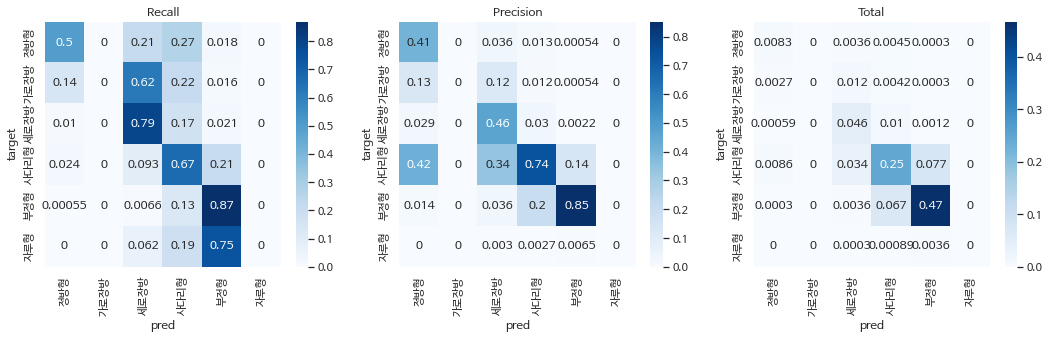


accuracy: 0.7656667828559875, 0.7656667828559875
recall: 0.4726288914680481
precisoin: 0.40978989005088806
f1-score: 0.43897196650505066



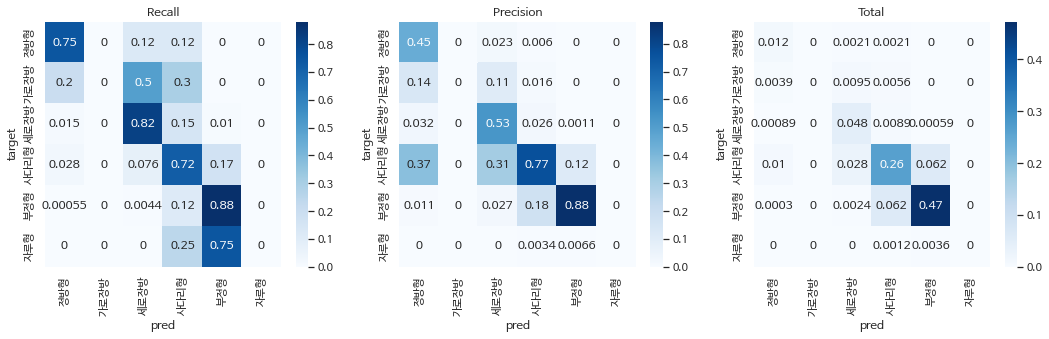


accuracy: 0.7962577939033508, 0.7962577939033508
recall: 0.5290495157241821
precisoin: 0.43711256980895996
f1-score: 0.47870680689811707



/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 6 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


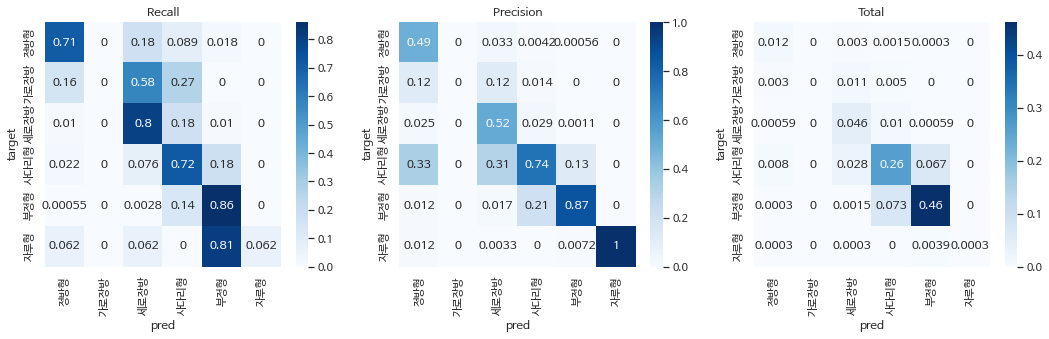


accuracy: 0.7825957536697388, 0.7825957536697388
recall: 0.5260097980499268
precisoin: 0.6033715605735779
f1-score: 0.5620410442352295



In [ ]:
for i in range(5):
  model_evaluation(torch.load(f'model{i}.pth'), YP_loader, classes)
  print()

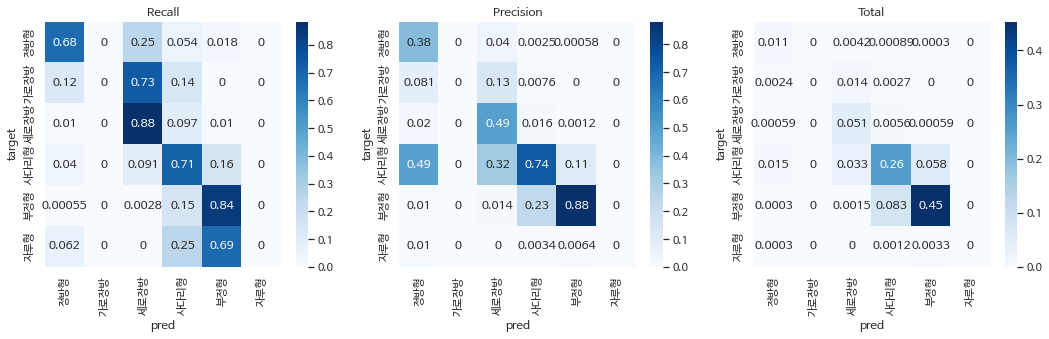


accuracy: 0.7739827632904053, 0.7739827632904053
recall: 0.518964946269989
precisoin: 0.415114164352417
f1-score: 0.46126648783683777


In [ ]:
model5 = torch.load('model5.pth')
model_evaluation(model5, YP_loader, classes)

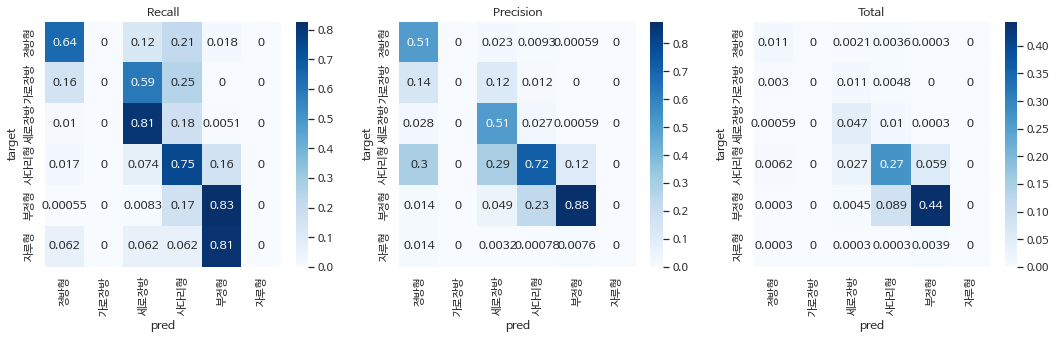


accuracy: 0.7733888030052185, 0.7733888030052185
recall: 0.5036143064498901
precisoin: 0.434526264667511
f1-score: 0.4665263295173645


In [ ]:
model6 = torch.load('model6.pth')
model_evaluation(model6, YP_loader, classes)

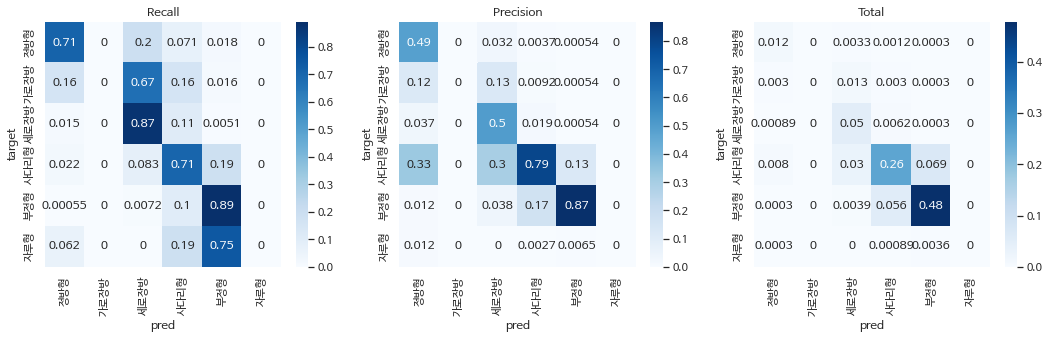


accuracy: 0.7968518137931824, 0.7968518137931824
recall: 0.5300496816635132
precisoin: 0.4415785074234009
f1-score: 0.48178622126579285


In [ ]:
model7 = torch.load('model7.pth')
model_evaluation(model7, YP_loader, classes)

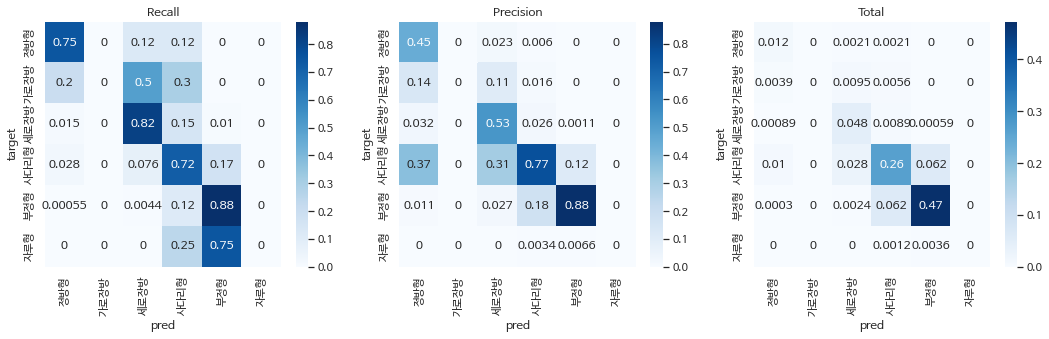


accuracy: 0.7962577939033508, 0.7962577939033508
recall: 0.5290495157241821
precisoin: 0.43711256980895996
f1-score: 0.47870680689811707


<Figure size 432x288 with 0 Axes>

In [ ]:
model3 = torch.load('model3.pth')
model_evaluation(model3, YP_loader, classes)
plt.savefig('cf_matrix.png')

#추가 작업

In [ ]:
yp_Y2 = torch.clone(yp_Y).to(device)
yp_Y2[yp_Y2==2]=1
yp_Y2[yp_Y2==3]=2
yp_Y2[yp_Y2==4]=3
yp_Y2[yp_Y2==5]=3

YPset2 = TensorDataset(yp_X, yp_Y2)
YP_loader2 = torch.utils.data.DataLoader(YPset2, batch_size=yp_Y.size(0), shuffle=False, num_workers=0)

In [ ]:
classes2 = ['정방형', '장방형', '사다리형', '부정형']
num_classes2 = len(classes2)

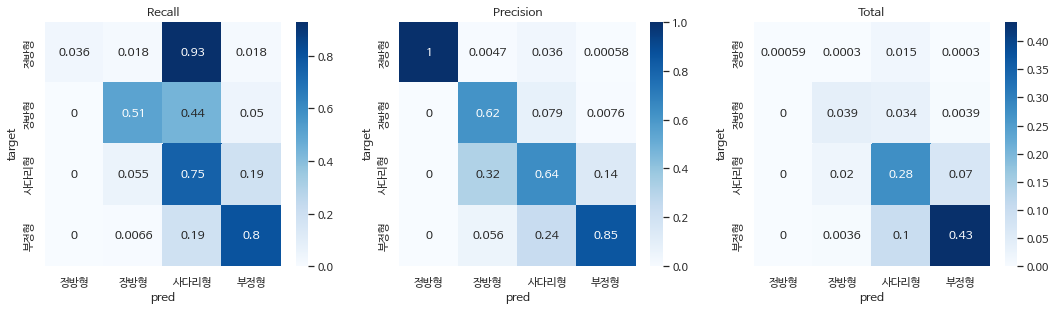


accuracy: 0.7493317723274231, 0.7493317723274231
recall: 0.5253370404243469
precisoin: 0.7793325185775757
f1-score: 0.6276105642318726


In [ ]:
model11 = torch.load('model11.pth')
model_evaluation(model11, YP_loader2, classes2)